In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

This notebook will contain the instructions to follow to build a Markov Model for the Isoleucine side chains from scratch as we have in the related publication. 

We thank the pyEmma developpers, as much of the code here comes from their package (or was slighty adapted for our purposes).

In [2]:
import pickle

def save_pickle(out_path, data):
    with open(out_path, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def load_pickle(pickle_path):
    with open(pickle_path, 'rb') as handle:
        return pickle.load(handle)

In [3]:
# Define path to data we will work with:

root_path = '/fileserver/pine/pine2/cchampion/NMR/ubiquitin/example_traj'

top = f'{root_path}/ubq_desolv.gro'
traj = f'{root_path}/traj_4us_PBC_fit.xtc' # trajectory from gromacs 

ile_traj = f'{root_path}/ile_13.xtc' # trajectory with only the Ile13 atoms included (used to re-evaluate dihedral energies)
ile_energies = np.loadtxt(f'{root_path}/ile_13.xvg', comments =['@', '#'], unpack=True) # dihedral angle energies

## 1: Extract the dihedral angles from the trajectory

In [4]:
import MDAnalysis as mda
from MDAnalysis.analysis.dihedrals import Dihedral, Janin, Ramachandran

In [5]:
u = mda.Universe(top, traj)
r_ile = u.select_atoms("resname ILE and resid 13")
J = Janin(r_ile).run()
dihedrals = J.results.angles[:, 0, :].T # (chi and chi2)

In [6]:
# Save the data to a pickle / numpy array to load it more easily.
np.save(f'{root_path}/ile13_side_chain_dihedrals.npy', J.results.angles[:, 0, :].T)
dihedrals = np.load(f'{root_path}/ile13_side_chain_dihedrals.npy')

## 2: Make a Markov Model in the 2-D space of $\chi_1$ and $\chi_2$

### 2.a Cluster data using energy based clustering (with periodic boundary conditions)

In [7]:
# note it is possible to play around with the hyperparameters of EBC to make sure clustering is done well! 

In [8]:
from ebc.Clustering import EBC
# can be installed with: pip install git+https://github.com/rinikerlab/EnergyBasedClustering.git

ebc = EBC(n_clusters=9, pca_components=2, temperature=5, knn=20, use_sparse=False, n_samples=5000, 
          boxsize= 360, proto_radius=5,
         )
ebc.fit(dihedrals.T, ile_energies[1:])

Using 1057 proto clusters.
Using the eigenvector corresponding to an eigenvalue of 1.0000000000000024.


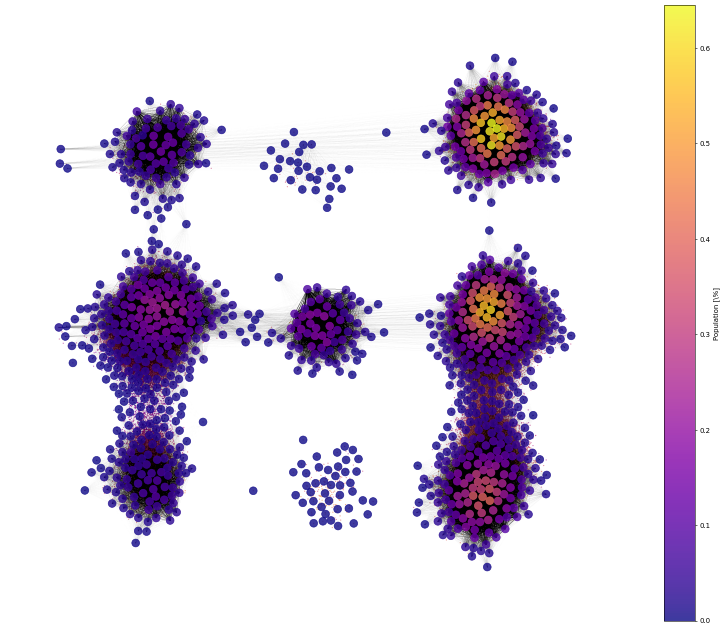

In [9]:
ebc.plot_graph(dpi=50);

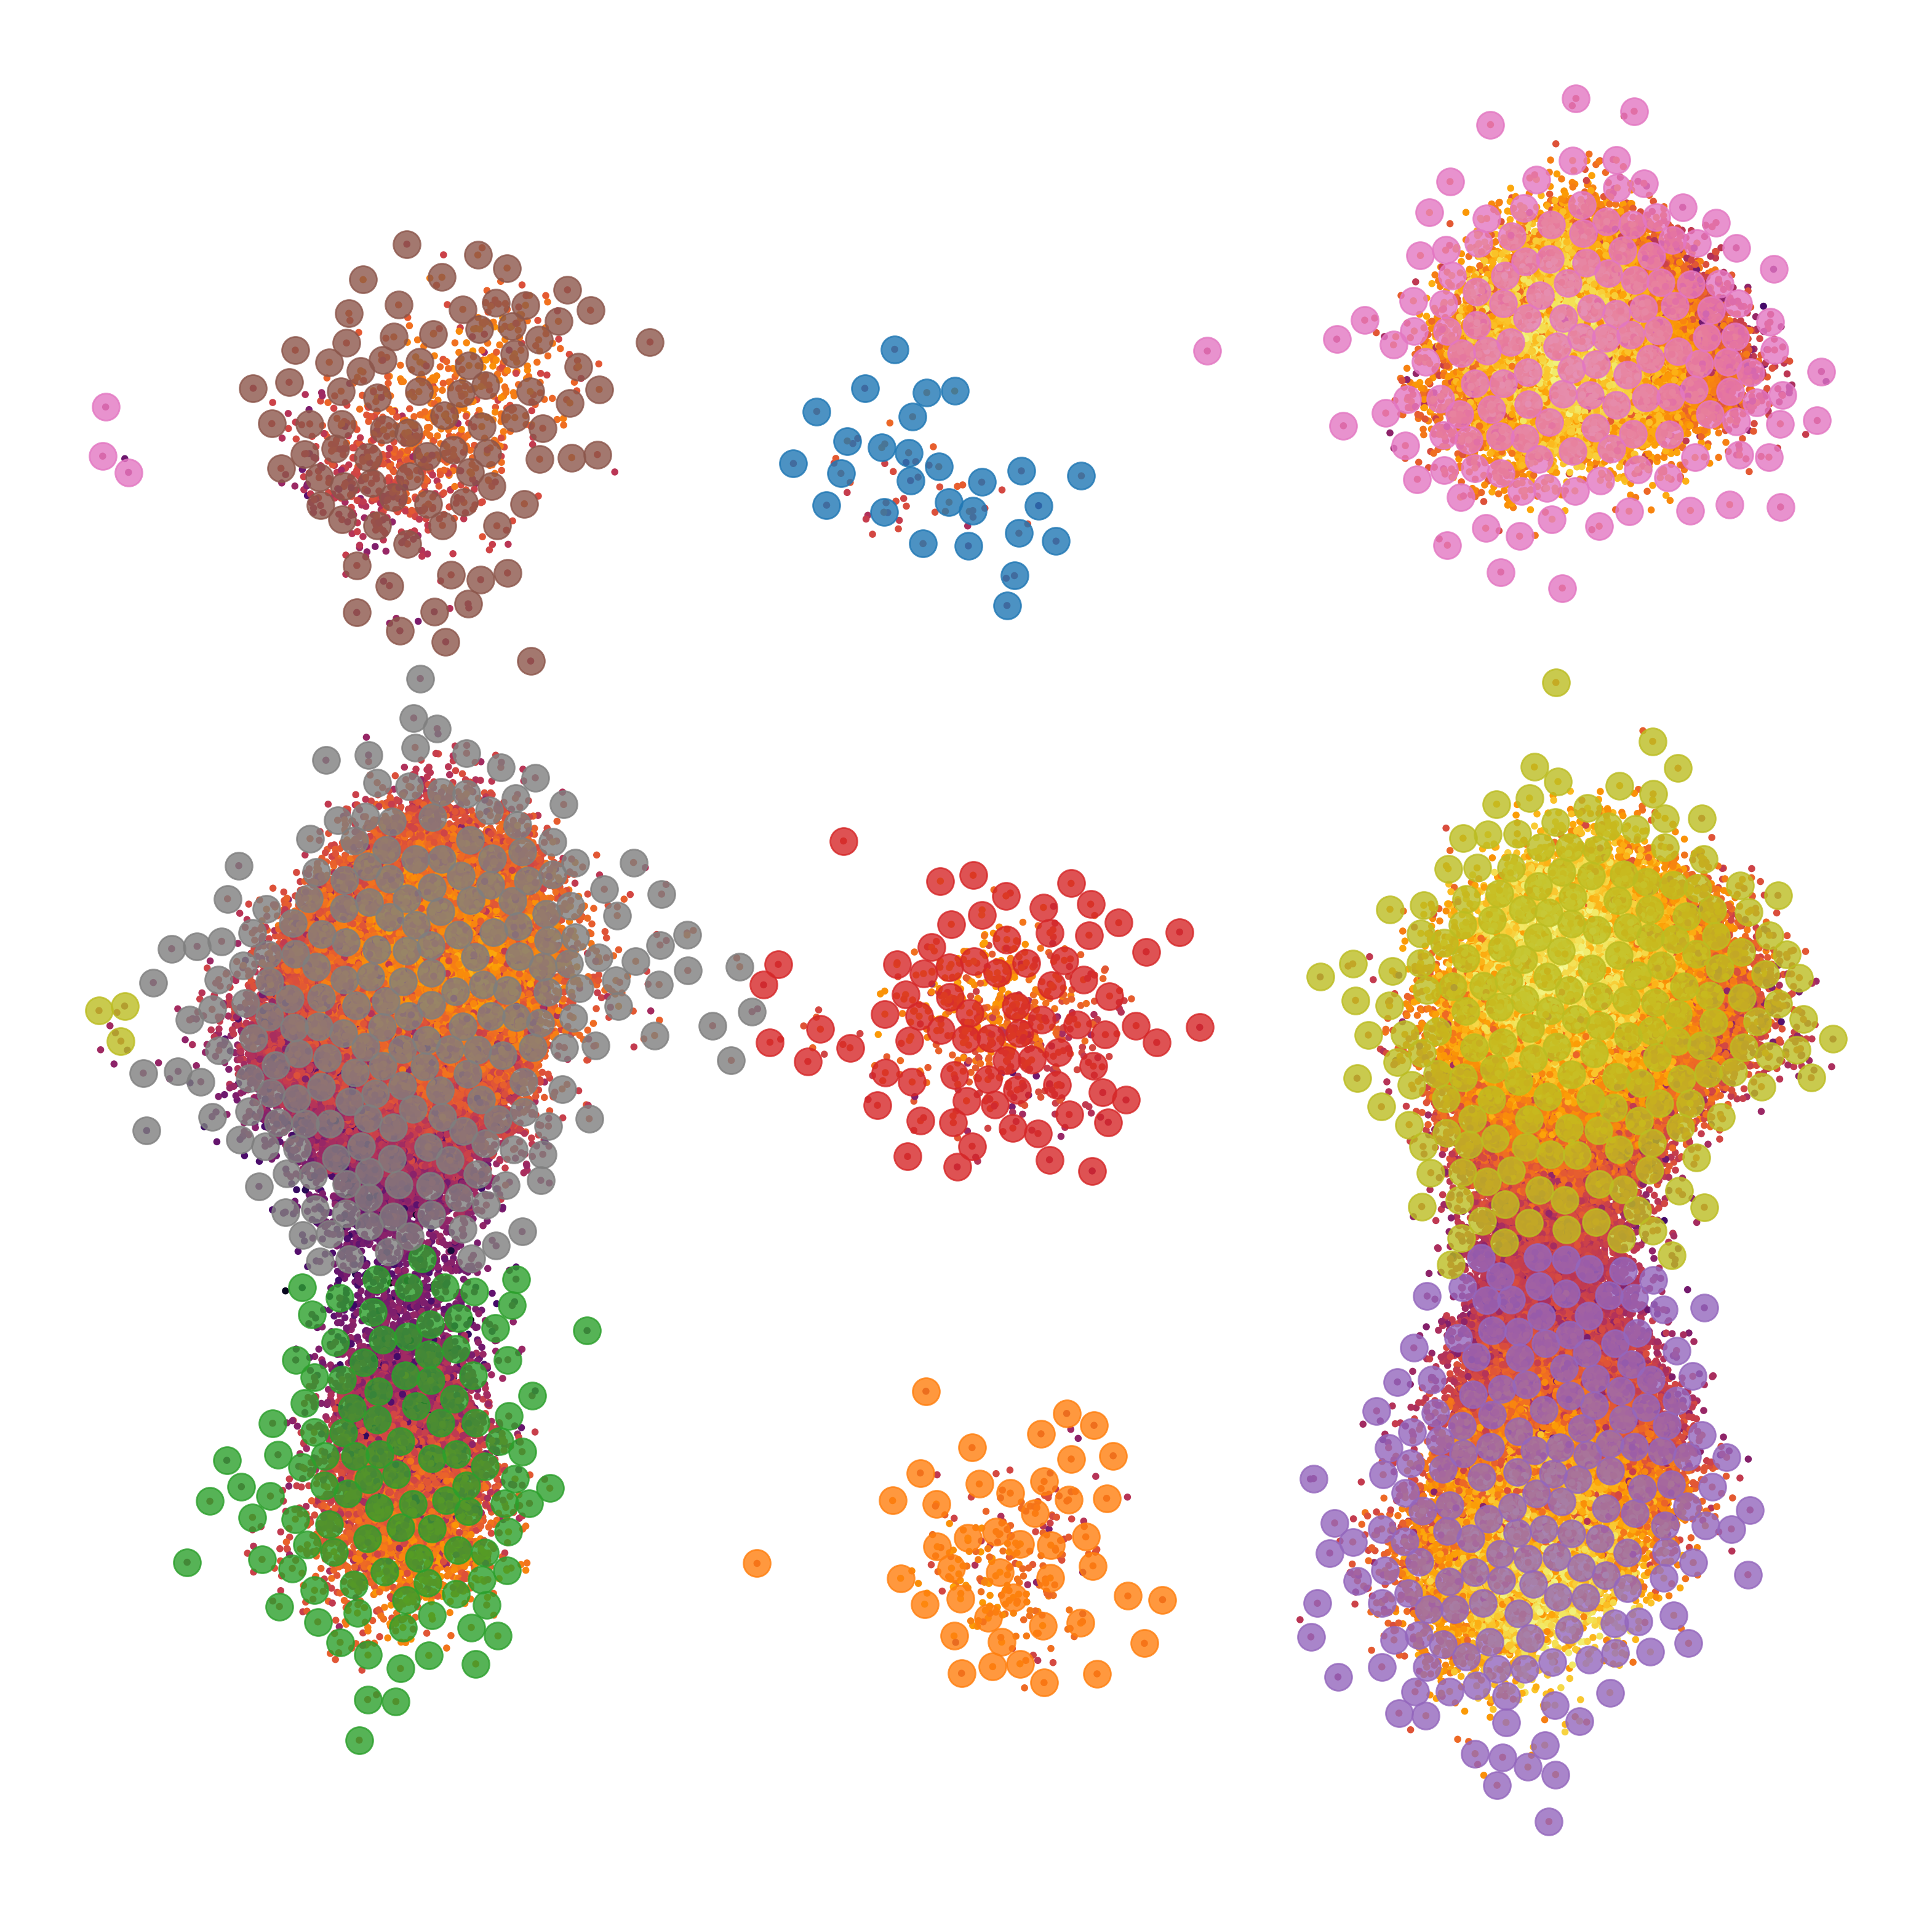

In [10]:
ebc.show();

### 2.b Map back clustering to full dataset 
clustering is done using proto-clusters for efficiency so here we map the clustering back to the full trajectory to create a discretized trajectory dtraj from which we can build a MSM

In [11]:
tmp_clusters = ebc._proto_labels

dtraj = np.zeros(len(ile_energies.T), dtype = int)

for i, (key, values) in enumerate(ebc._proto_clusters.items()):
    # keys  = cluster centers and values are all values in that proto-cluster
    dtraj[key] = tmp_clusters[i]    
    for j in values:
        dtraj[j] = tmp_clusters[i]    

### 2.c Make the Markov Model with PyEmma
As usually done with MSM building, we scan a range of lag times to make sure our implied timescales are converged

In [12]:
import mdtraj as md
import pyemma

estimating BayesianMSM:   0%|                                                                                 …

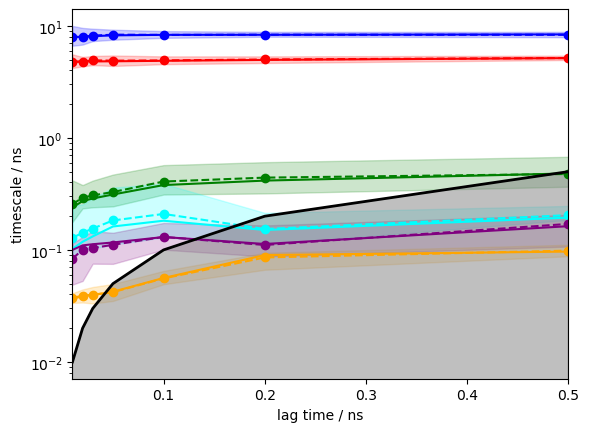

In [13]:
lags = [1, 2, 3, 5, 10, 20, 50]
its = pyemma.msm.its(dtraj, lags=lags, nits=6, errors='bayes', n_jobs=1)
pyemma.plots.plot_implied_timescales(its, units='ns', dt=10/1000, );

In [14]:
# once we know the lag time we want to work with, we create the actual model
msm = pyemma.msm.bayesian_markov_model(dtraj, lag=5, dt_traj='0.01 ns')

pyemma.msm.estimators.bayesian_msm.BayesianMSM[7]: Sampling MSMs:   0%|                                       …

#### Inspect eigenmodes of the MSM

The first eigenvector is one: True (min=0.9999999999999853, max=1.000000000000023)


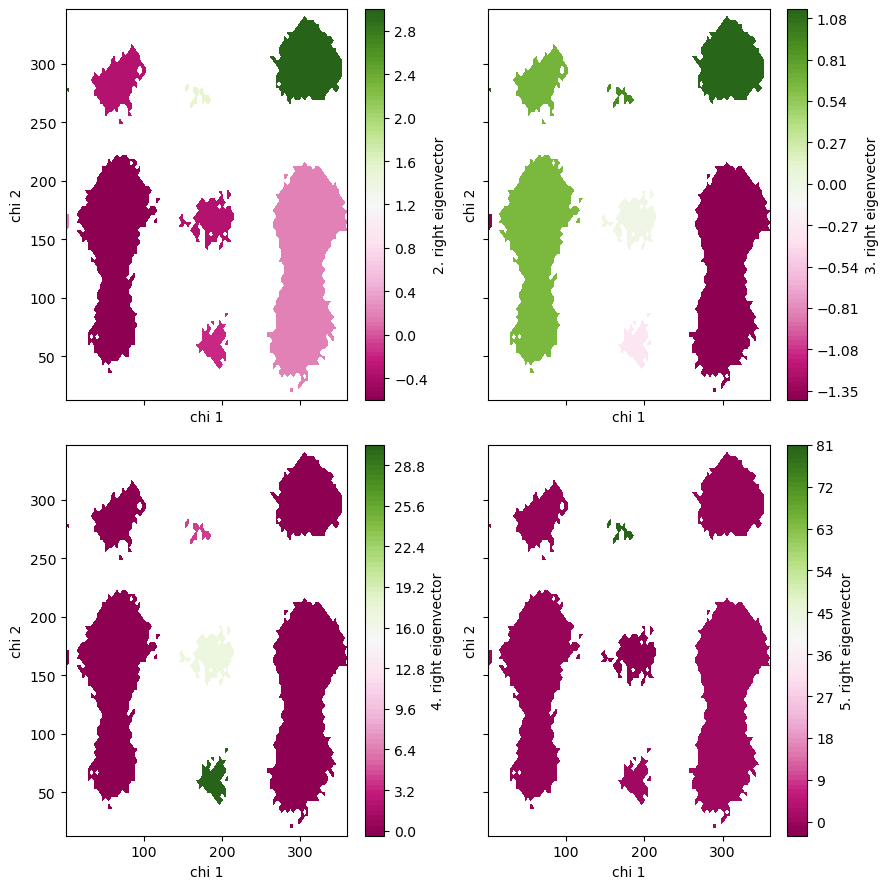

In [15]:
from custom_plots import plot_eigenmodes
# It is possible to play with the number of eigenmodes to display with variable num
fig = plot_eigenmodes(msm, dihedrals.T, num=4) 

#### Extract implied timescales

 1 8.2  ± 0.381 ns
 2 4.7  ± 0.299 ns
 3 0.3  ± 0.072 ns
 4 0.2  ± 0.062 ns


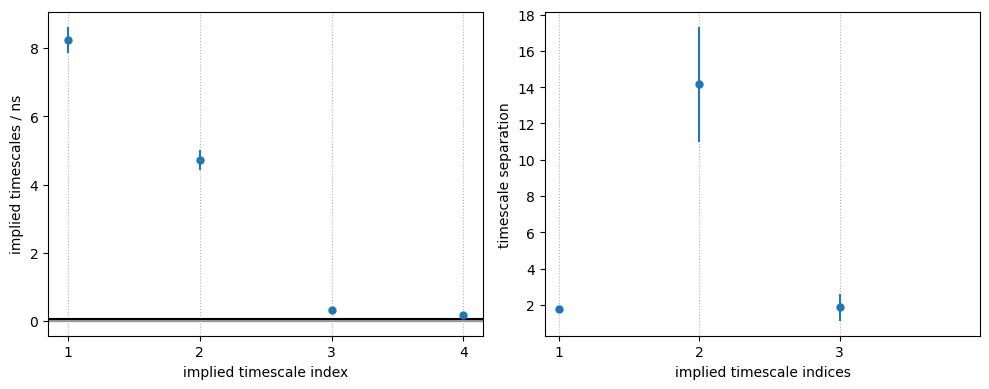

In [16]:
from custom_plots import plot_its

nits = 4

fig = plot_its(msm, nits=nits)
timescales_mean = msm.sample_mean('timescales', k=nits)
timescales_std = msm.sample_std('timescales', k=nits)
for nit in range(nits):
    print(f'{nit+1: } {round(timescales_mean[nit],1)}  \u00B1 {round(timescales_std[nit],3)} ns')

#### Metastable distribution + PCCA

state	π		G/kT
1	0.000154	8.776944
2	0.000602	7.414651
3	0.001530	6.482777
4	0.002205	6.117181
5	0.020685	3.878341
6	0.089996	2.407995
7	0.108650	2.219620
8	0.227875	1.478959
9	0.548303	0.600927


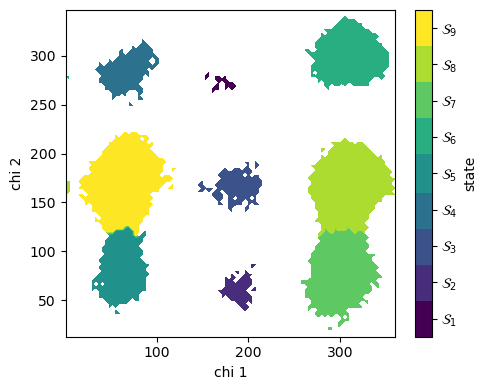

In [17]:
from custom_plots import plot_pcca, plot_metastable

# Here we keep 9 states to keep the resolution between all states so PCCA+ reclustering does "nothing", 
#but it is in principle possible to recluster to have a more coarse grained picture

nstates = 9
msm.pcca(nstates) 

# fig, axes = plot_metastable(msm, dihedrals.T, ) # not always that interesting here.

pis = np.zeros(nstates)

print('state\tπ\t\tG/kT')
for i, s in enumerate(msm.metastable_sets):
    pis[i] = msm.pi[s].sum()
    print('{}\t{:f}\t{:f}'.format(i + 1, pis[i], -np.log(pis[i])))

fig, axes = plot_pcca(msm, dihedrals.T, nstates)

#### Calculation of Mean First Passage Times [MFPTs]

In [18]:
from itertools import product
mfpt = np.zeros((nstates, nstates))
for i, j in product(range(nstates), repeat=2):
    mfpt[i, j] = msm.mfpt( 
        msm.metastable_sets[i],
        msm.metastable_sets[j])
      
from pandas import DataFrame
print(f'MFPT (i > j) / [ns]:')
MPFT_df = DataFrame(np.round(mfpt, decimals=1), index=range(1, nstates + 1), columns=range(1, nstates + 1))
MPFT_df

# read as from (row id) towards (col id)

MFPT (i > j) / [ns]:


1      2      3     4     5     6     7     8     9
1     0.0  396.3  149.6  37.5  12.0  37.9  13.8  13.4   9.5
2  1222.6    0.0   50.3  36.8   7.8  85.4   8.8   8.4   5.3
3  1241.9  316.3    0.0  35.3   6.1  87.2  10.8  10.4   3.6
4  1245.1  418.0  150.6   0.0   3.6  83.8  15.2  14.8   1.2
5  1248.2  417.6  149.9  32.2   0.0  89.8  15.4  15.0   0.1
6  1202.3  423.5  159.3  40.6  18.0   0.0  13.0  12.6  15.5
7  1247.1  415.7  151.8  40.9  12.5  81.9   0.0   0.2  10.1
8  1247.1  415.7  151.8  40.9  12.5  81.9   0.6   0.0  10.0
9  1248.1  417.6  149.9  32.2   2.5  89.8  15.4  15.0   0.0

In [20]:
from custom_plots import plot_msm_final

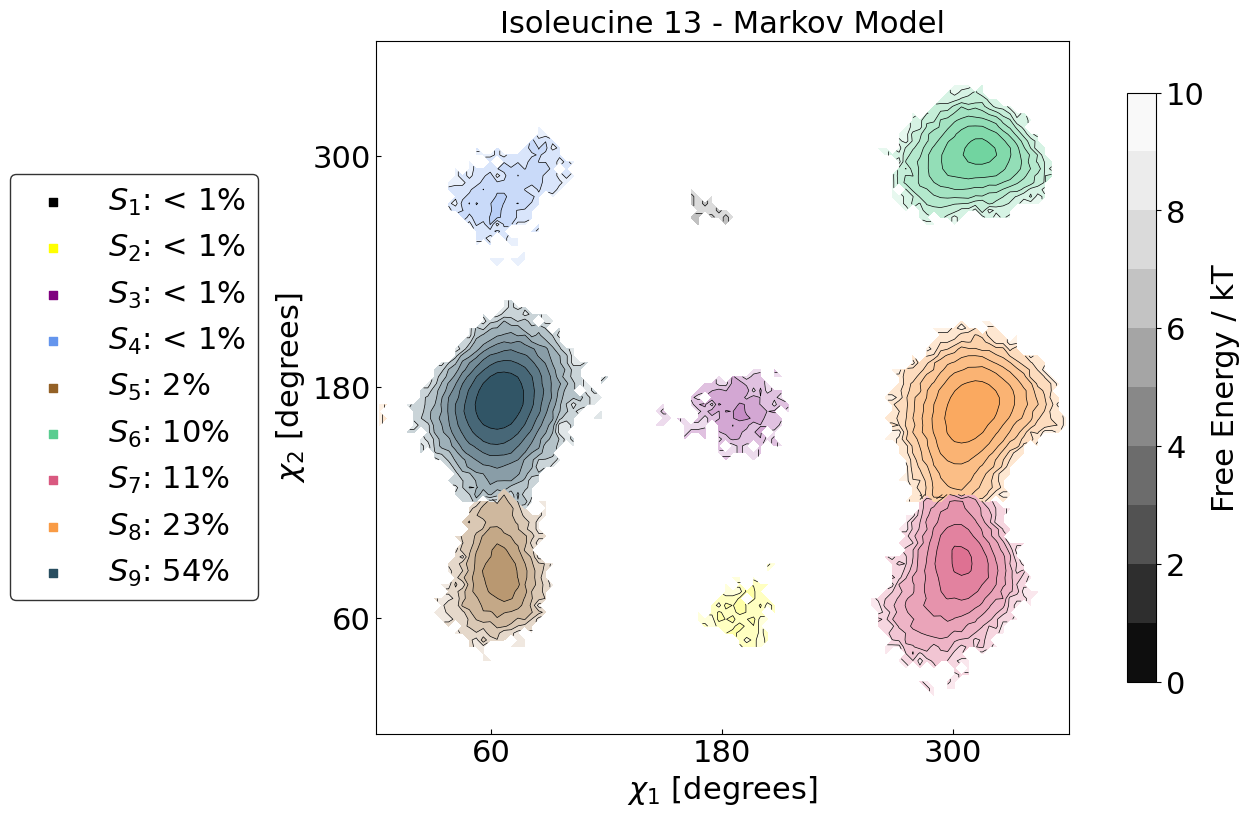

In [21]:
metastable_traj = msm.metastable_assignments[dtraj]

# Set the colors, + make sure the coloring is always the same when we count from the most-populated cluster
# regardless of the number of clusters
colors = ['#284E60', '#F99B45', '#D95980', '#59CD90', '#946126', 'cornflowerblue', 'purple', 'yellow', 'black']
colors = colors[:max(msm.metastable_assignments)+1][::-1]

fig, ax, contours  = plot_msm_final(dihedrals, metastable_traj, 
                          alpha = 0.95, title = f'Isoleucine 13 - Markov Model', colors=colors, 
                          with_leg = True
                         )